In [5]:
get_ipython().magic('matplotlib notebook')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
import sys
import numpy as np
import time
import matplotlib
matplotlib.rcParams['contour.negative_linestyle']= 'solid'
import matplotlib.pyplot as plt
import matplotlib.patches as Polygon
import copy as cp
import cmocean

#+____IMPORT FESOM RELATET ROUTINES____________________________________________+
from set_inputarray  import *
from sub_fesom_mesh  import * 
from sub_fesom_data  import * 
from sub_fesom_plot  import *
from sub_fesom_moc   import *
from sub_climatology  import *
from colormap_c2c    import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
#+_____________________________________________________________________________+
#|                                                                             |
#|                         *** LOAD FVSOM MESH ***                             |
#|                                                                             |
#+_____________________________________________________________________________+
# for more options look in set_inputarray.py
inputarray=set_inputarray()
inputarray['save_fig'        ] = False
inputarray['save_figpath'    ] = '/home/ollie/pscholz/figures/paper_fesom2.0/'
inputarray['mesh_id'		 ] = 'COREv2'
inputarray['mesh_dir'		 ] = '/work/ollie/pscholz/mesh_fesom2.0/mesh_CORE2_final/'
try:
	mesh
except NameError:
	mesh = fesom_init_mesh(inputarray)
else:
	print(" --> ___FOUND FESOM MESH --> will use it!___________________________")

 --> ___FOUND FESOM MESH --> will use it!___________________________


# Calculate Meridional Overturning Circulation Profile

Use for the calculation of the Meridional Overturning Circulation (MOC) the equation for the calculation of the "Pseudostreamfunction". Condition for the calculation of the regional MOC (i.e AMOC, PMOC, IMOC) is that the domain over which the caluclation is carried out, is approximately sorounded by a coast (Bering Strait can be accouted as coast its just 30m deep). Since Atlantic, Pacific and Indian Ocean have no southern coastal boundary the AMOC and PMOC can just be calculated until -30°S and the meridional cumulativ integration has to be carried out from North to South instead South to North which leads to an additional minus sign in the calcualtion (see: sub_fesom_moc.py, line:137)
$${\int_E^W w(x',y,z) dx' = {{\partial\Psi} \over {\partial y}}}$$
$$ \textrm{GMOC:} ~~~  {\Psi(y,z) = \int_S^N {\int_E^W w(x',y',z) \cdot dx'} dy'} ~~$$
$$ \textrm{AMOC:} ~~~  {\Psi(y,z) = -\int_N^{-30S^\circ} {\int_E^W w(x',y',z) \cdot dx'} dy'} $$

     --> calculate GMOC from vertical velocities via meridional bins
         elpased time:0.7189228534698486s


<IPython.core.display.Javascript object>


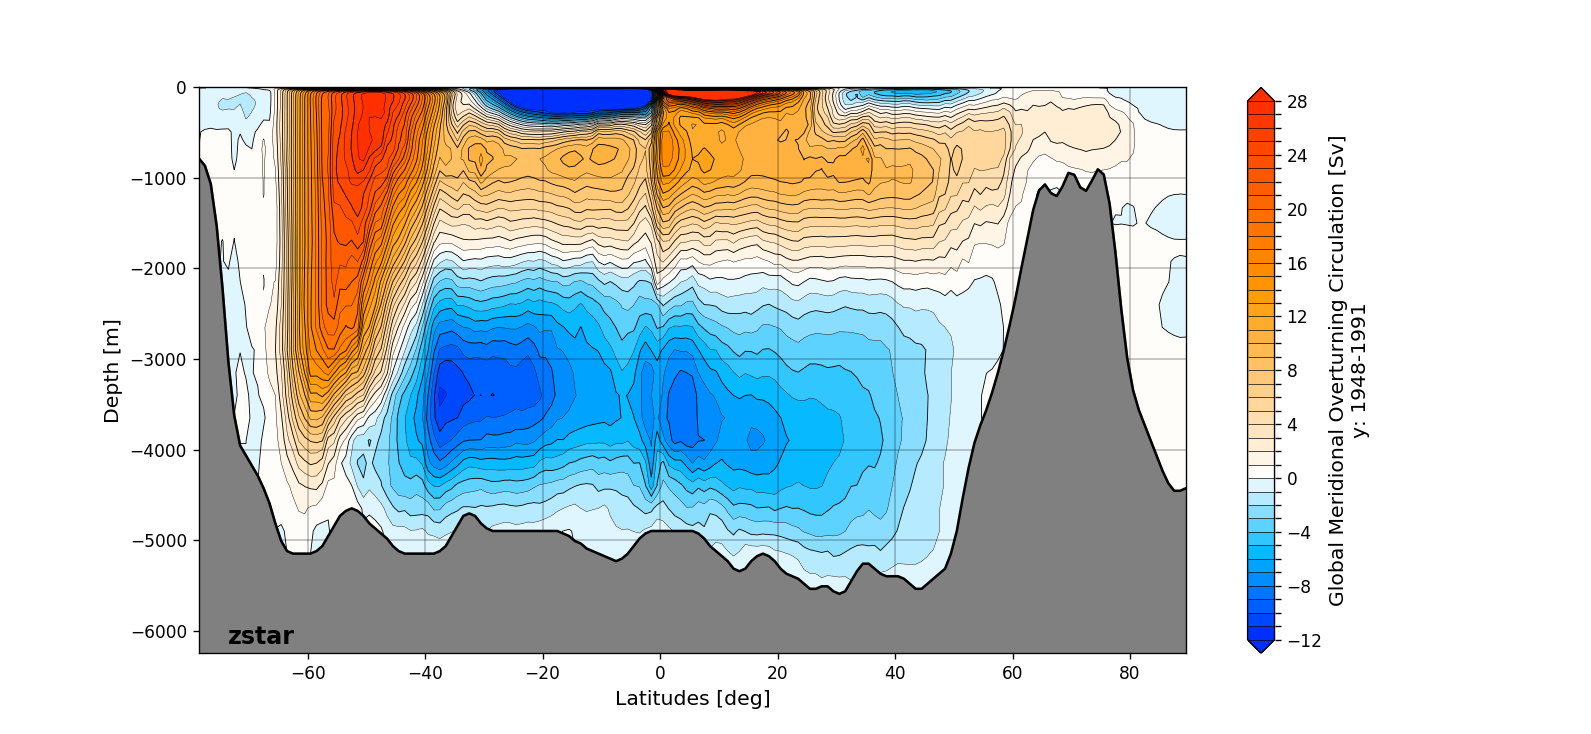

     --> calculate AMOC from vertical velocities via meridional bins
         elpased time:9.755096912384033s


<IPython.core.display.Javascript object>


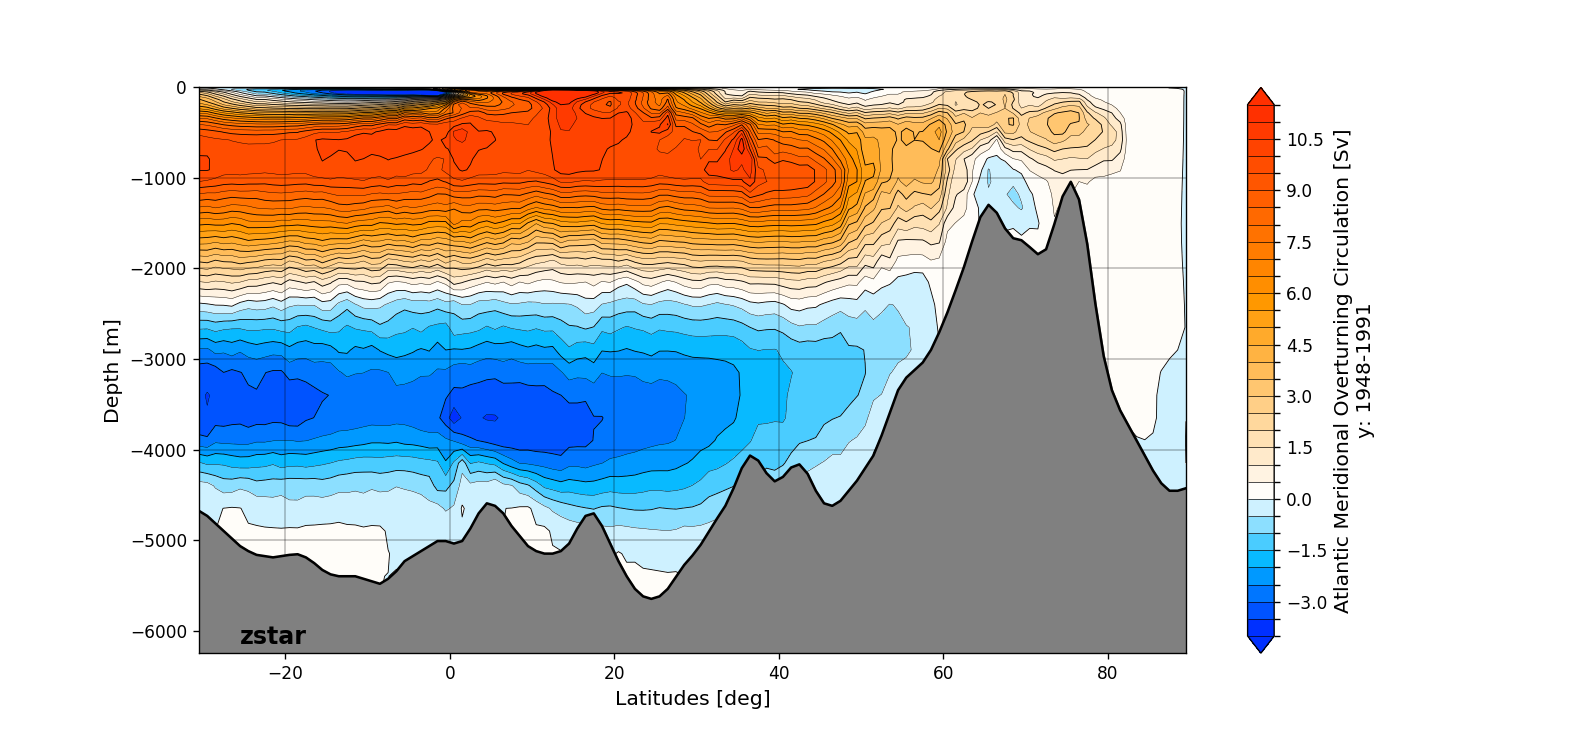

     --> calculate PMOC from vertical velocities via meridional bins
         elpased time:7.160600423812866s


<IPython.core.display.Javascript object>


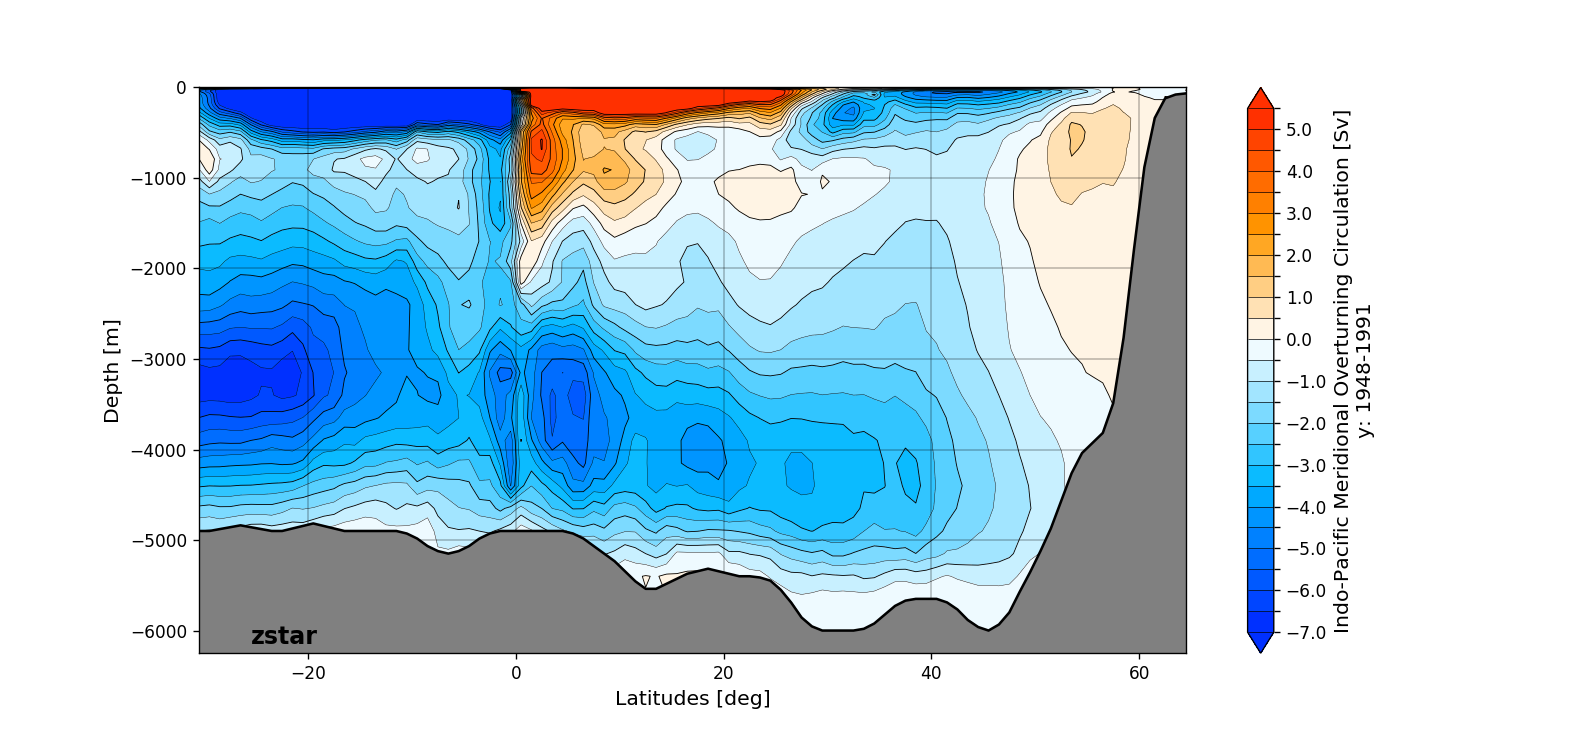

In [7]:
#____________________________________________________________________________________________________
# load vertical velocity data
data1 		 	= fesom_data(inputarray) 
data1.descript  = 'zstar'
data1.path      = '../results/'+data1.descript+'_pgf/'+'/withoutPC-3/'
data1.var 		= 'w'
data1.year		= [1948,1992]
data1.cmap      = 'blue2red'
data1.month		= [1,2,3,4,5,6,7,8,9,10,11,12]
fesom_load_data_horiz(mesh,data1,do_output=False)

#____________________________________________________________________________________________________
#select XMOC
which_moc = 'gmoc'
#____________________________________________________________________________________________________
# calc XMOC
moc1,lat,bottom  = calc_xmoc(mesh,data1,which_moc=which_moc)
# moc1,lat,bottom,elemidx  = calc_xmoc(mesh,data1,which_moc=which_moc,out_elemidx=True)
#____________________________________________________________________________________________________
# plot XMOC
fig,ax=plot_xmoc(lat,mesh.zlev,moc1,bottom=bottom,which_moc=which_moc,str_descript=data1.descript,str_time=data1.str_time)
#____________________________________________________________________________________________________
# save XMOC
if inputarray['save_fig']==True:
    print(' --> save figure: png')
    str_times= data1.str_time.replace(' ','').replace(':','') 
    sfname = 'plot_'+data1.descript+'_'+which_moc+'_'+str_times+'.png'
    sdname = inputarray['save_figpath'] 
    plt.savefig(sdname+sfname, \
       format='png', dpi=600, \
       bbox_inches='tight', pad_inches=0,\
       transparent=True,frameon=True)
    
#____________________________________________________________________________________________________    
which_moc = 'amoc'
moc1,lat,bottom  = calc_xmoc(mesh,data1,which_moc=which_moc)
fig,ax=plot_xmoc(lat,mesh.zlev,moc1,bottom=bottom,which_moc=which_moc,str_descript=data1.descript,str_time=data1.str_time)
which_moc = 'pmoc'
moc1,lat,bottom  = calc_xmoc(mesh,data1,which_moc=which_moc)
fig,ax=plot_xmoc(lat,mesh.zlev,moc1,bottom=bottom,which_moc=which_moc,str_descript=data1.descript,str_time=data1.str_time)

# Calculate Meridional Overturning Circulation Time-Series

 --> CALC YEAR:
|1948|1949|1950|1951|1952|1953|1954|1955|1956|1957|
|1958|1959|1960|1961|1962|1963|1964|1965|1966|1967|
|1968|1969|1970|1971|1972|1973|1974|1975|1976|1977|
|1978|1979|1980|1981|1982|1983|1984|1985|1986|1987|
|1988|1989|1990|1991

<IPython.core.display.Javascript object>


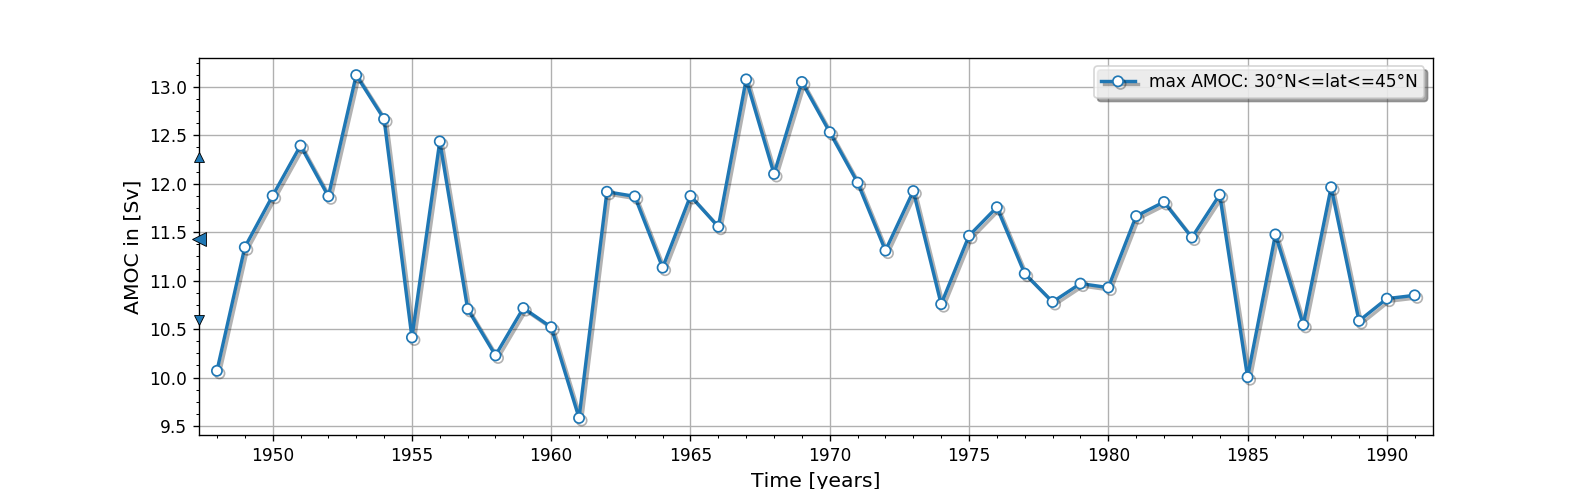

In [8]:
which_moc='amoc'
# which_lat=[26.0, 35.0, 40.0,'max']
which_lat=['max']
#____________________________________________________________________________________________________
# load vertical velocity data
# data1 		 	= fesom_data(inputarray) 
# data1.descript  = 'zstar'
# data1.path      = '../results/'+data1.descript+'_pgf/'+'/withoutPC-2/'
# data1.var 		= 'w'
# data1.year		= [1948,2009]
# data1.month		= [1,2,3,4,5,6,7,8,9,10,11,12]

#____________________________________________________________________________________________________
# calc MOC time-series
count=0
print(' --> CALC YEAR:')
moc_t = np.zeros((data1.year[1]-data1.year[0]+1,len(which_lat)))
time  = np.zeros((data1.year[1]-data1.year[0]+1,))
datayr=cp.deepcopy(data1)
for year in range(data1.year[0],data1.year[1]+1):
    #_______________________________________________________________________________________________
    print('|'+str(year),end='')
    if np.mod(count+1,10)==0: print('|')
    #_______________________________________________________________________________________________
    datayr.year		= [year,year]
    fesom_load_data_horiz(mesh,datayr,do_output=False)
    if count==0:
        moc_prof,lat,bottom,elemidx  = calc_xmoc(mesh,datayr,which_moc=which_moc,out_elemidx=True,do_output=False)
    else:
        moc_prof,lat,bottom  = calc_xmoc(mesh,datayr,which_moc=which_moc,in_elemidx=elemidx,do_output=False)
    #_______________________________________________________________________________________________
    moc_d=moc_prof[np.where(mesh.zlev<=-500)[0],:]
    count_lat=0
    for lati in which_lat:
        if lati=='max':
            moc_l= moc_d[:,np.where((lat>=30) & (lat<=45))[0]]
        else:
            moc_l= moc_d[:,np.where(lat>=lati)[0][0]]
        moc_t[count,count_lat]=moc_l.max()
        count_lat=count_lat+1
    time[count]=year    
    count=count+1
    
#____________________________________________________________________________________________________
# plot MOC time-series
fig,ax=plot_xmoc_tseries(time,moc_t,which_lat,which_moc)    